# Maximize the likelihood using iminuit (CMB parameterization)

See tutorials here: https://nbviewer.jupyter.org/github/scikit-hep/iminuit/tree/master/tutorial/

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['savefig.dpi'] = 140
mpl.rcParams['figure.dpi'] = 140
import numpy as np
# our own modules
from lace.data import data_MPGADGET
from lace.emulator import gp_emulator
from lace.emulator import p1d_archive
from lace.likelihood import likelihood
from lace.likelihood import full_theory
from lace.cosmo import camb_cosmo
from lace.sampler import iminuit_minimizer
import time

### Note that this minimiser is quite fragile, it only works when starting near the truth

Setup mock data, from one of simulations in the suite

In [2]:
# specify simulation to use to generate synthetic data
test_sim_label='nu'
if type(test_sim_label)==int:
    drop_sim_number=test_sim_label
    print('will drop sim number {} from emulator'.format(drop_sim_number))
else:
    drop_sim_number=None

In [3]:
# specify simulation suite and P1D mesurements
basedir="/lace/emulator/sim_suites/Australia20/"
skewers_label='Ns500_wM0.05'
p1d_label=None
z_max_data=4
data=data_MPGADGET.P1D_MPGADGET(basedir=basedir,
                                skewers_label=skewers_label,
                                sim_label=test_sim_label,
                                zmax=z_max_data,pivot_scalar=0.05)

Sim has neutrinos
H0 = 6.7000E+01, Omega_b h^2 = 2.2000E-02, Omega_c h^2 = 1.2000E-01, Omega_k = -5.5511E-17, Omega_nu h^2 = 3.2257E-03, A_s = 2.2507E-09, n_s = 9.6757E-01, alpha_s = 0.0000E+00


In [4]:
# access true cosmology in simulation, will be used later
sim_cosmo=data.mock_sim.sim_cosmo

Setup archive of P1D measurements from simulations to train the emulator

In [5]:
# Set up emulator training set
z_max_emu=4
archive=p1d_archive.archiveP1D(basedir=basedir,drop_sim_number=drop_sim_number,
                            drop_tau_rescalings=True,z_max=z_max_emu,
                            drop_temp_rescalings=True,skewers_label=skewers_label)

In [6]:
## Build emulator
paramList=['mF', 'sigT_Mpc', 'gamma', 'kF_Mpc', 'Delta2_p', 'n_p']
# specify k range
kmax_Mpc=8
emu=gp_emulator.GPEmulator(basedir,p1d_label,skewers_label,z_max=z_max_emu,
                                verbose=False,paramList=paramList,train=True,
                                asymmetric_kernel=True,rbf_only=True,
                                emu_type="k_bin",passarchive=archive,
                                kmax_Mpc=kmax_Mpc)

 /Users/font/opt/anaconda3/envs/lya_cosmo/lib/python3.8/site-packages/paramz/parameterized.py:61: RuntimeWarning:Don't forget to initialize by self.initialize_parameter()!


Training GP on 270 points
Optimised


Setup FullTheory, explicit in case we don't use any cosmo param and likelihood gets confused

In [7]:
# specify whether to use true cosmology in simulation as fiducial (easier test)
use_sim_fid=False
if use_sim_fid:
    print('use true cosmo as fiducial')
    camb_cosmo.print_info(sim_cosmo)
    camb_model_sim=CAMB_model.CAMBModel(zs=data.z,cosmo=sim_cosmo)
    theory=full_theory.FullTheory(zs=data.z,emulator=emu,true_camb_model=camb_model_sim,use_camb_fz=True)
else:
    theory=full_theory.FullTheory(zs=data.z,emulator=emu,use_camb_fz=True)
    print('use default cosmo as fiducial')
    camb_cosmo.print_info(theory.true_camb_model.cosmo)

use default cosmo as fiducial
H0 = 6.7000E+01, Omega_b h^2 = 2.2000E-02, Omega_c h^2 = 1.2000E-01, Omega_k = 0.0000E+00, Omega_nu h^2 = 0.0000E+00, A_s = 2.1000E-09, n_s = 9.6500E-01, alpha_s = 0.0000E+00


Setup likelihood and free parameters

In [8]:
# Likelihood parameters (option to fix cosmology)
fix_cosmo=False
if fix_cosmo:
    assert use_sim_fid,'do you want to fix the cosmology when not using the right one?'
    like_params=["ln_tau_0","ln_sigT_kms_0","ln_gamma_0"]
    like_param_limits=[[-0.2, 0.2],[-0.5, 0.5],[-0.5, 0.5]]
else:
    like_params=["As","ns","ln_tau_0","ln_sigT_kms_0","ln_gamma_0"]
    like_param_limits=[[1.0e-9,3.0e-9 ], [0.90, 1.05], [-0.5, 0.5],
            [-0.5, 0.5], [-0.5, 0.5]]

In [9]:
like=likelihood.Likelihood(data=data,theory=theory,
                            free_param_names=like_params,
                            free_param_limits=like_param_limits,
                            verbose=False,prior_Gauss_rms=0.5)

starting point
As = 1.9999999999999997e-09
ns = 0.9750000000000001
ln_tau_0 = 0.0
ln_sigT_kms_0 = 0.0
ln_gamma_0 = 0.0
starting chi2 35.2669551936737


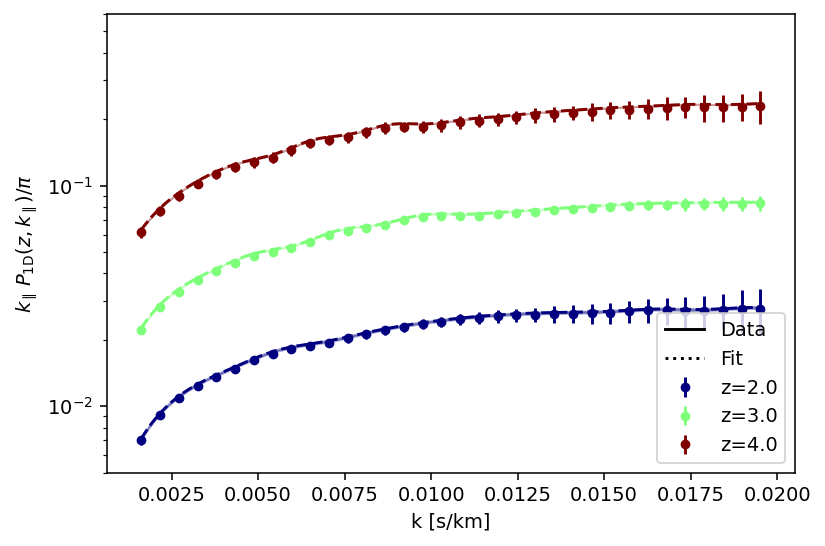

In [10]:
## Evaluate log_prob at random point in parameter space
theta=np.ones(len(like_params))*0.5 ## Just pick the middle of likelihood space
print('starting point')
for par in like.parameters_from_sampling_point(theta):
    print(par.info_str())
chi2_test=like.get_chi2(theta)
print('starting chi2',chi2_test)
like.plot_p1d(plot_every_iz=4)

### Setup our own minimizer

In [11]:
minimizer = iminuit_minimizer.IminuitMinimizer(like)

In [12]:
minimizer.minimize()

will run migrad
------------------------------------------------------------------
| FCN = -24.02                  |     Ncalls=133 (133 total)     |
| EDM = 2.27e-05 (Goal: 0.0001) |            up = 0.5            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
will compute Hessian matrix


best-fit values = [0.49869145 0.42423626 0.49393819 0.43920671 0.50094777]


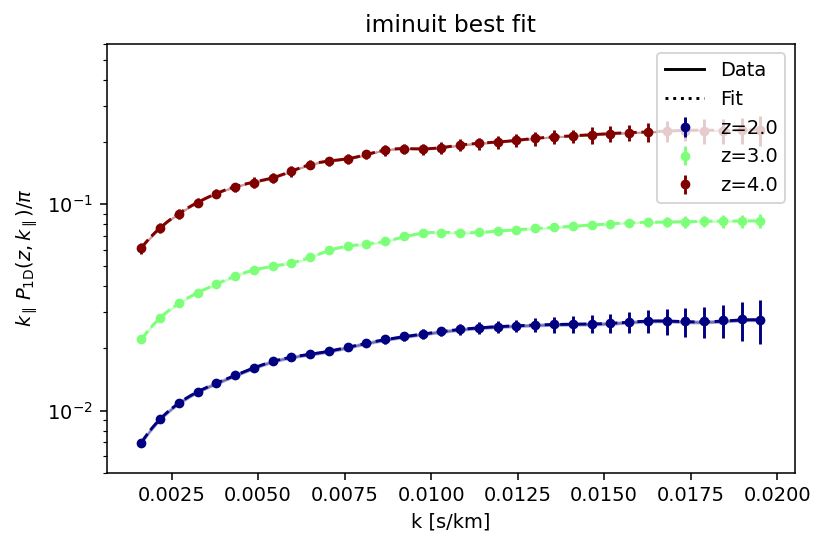

In [13]:
minimizer.plot_best_fit(plot_every_iz=4)

### Plot Gaussian contours after minimization

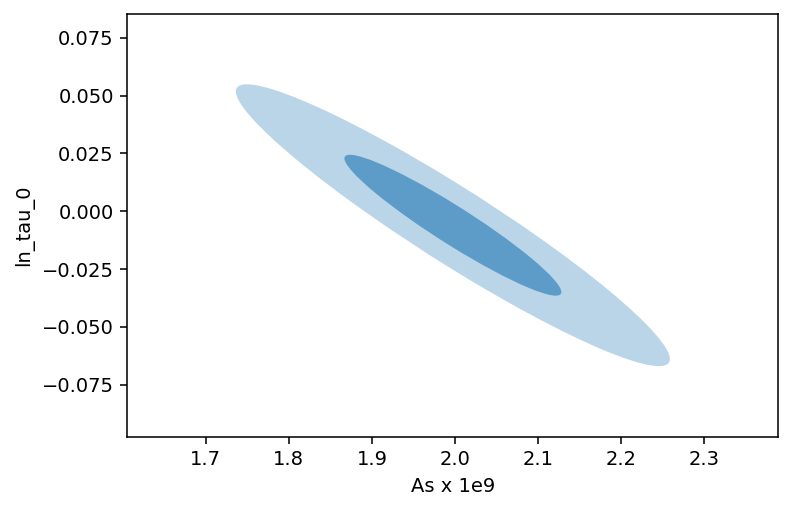

In [14]:
minimizer.plot_ellipses('As','ln_tau_0',cube_values=False) 

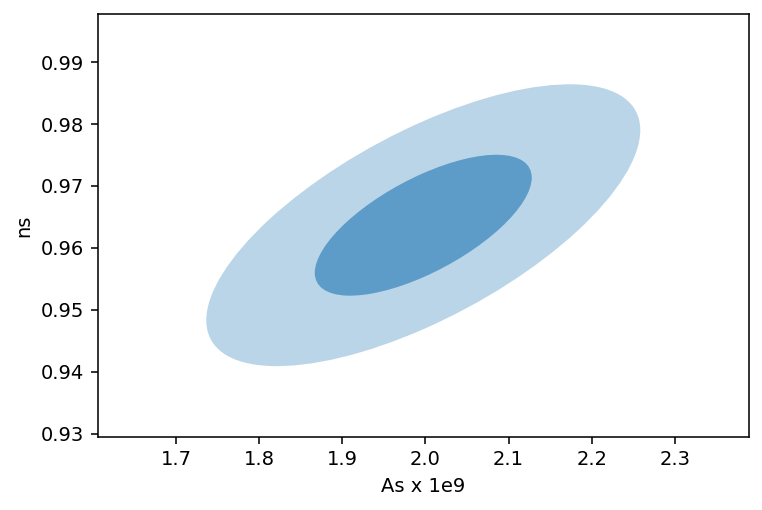

In [15]:
minimizer.plot_ellipses('As','ns',cube_values=False) 

In [16]:
if False:
    # compare with function from iminuit
    minimizer.plot_ellipses('As','ns',cube_values=True) 
    # this will take a while, it computes several minimizations
    minimizer.minimizer.draw_mncontour('x0','x1',numpoints=20)

# Run iminuit minimiser directly (without using our object)

In [17]:
from iminuit import Minuit

In [18]:
# setup iminuit
m = Minuit.from_array_func(like.minus_log_prob,theta,error=0.02,errordef=0.5)

In [19]:
# run optimiser
m.migrad()

------------------------------------------------------------------
| FCN = -24.02                  |     Ncalls=133 (133 total)     |
| EDM = 2.27e-05 (Goal: 0.0001) |            up = 0.5            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
------------------------------------------------------------------------------------------
|   | Name |   Value   | Hesse Err | Minos Err- | Minos Err+ | Limit-  | Limit+  | Fixed |
------------------------------------------------------------------------------------------
| 0 | x0   |   0.50    |   0.06    |            |            |         |         |       |
| 1 | x1   |   0.42    |   0.07    |            |            |         |         |       |
| 2 | x2   |   0.494   |   0.030   |            |            |         |         |       |
| 3 | x3   |   0.44    |   0.15    |            |            |         |         |       |
| 4 | x4   |   0.50    |   0.06    |            |            |         |         |       |
------------------------------------------------------------------------------------------

In [20]:
# access results again
print('best fit values =',m.values)
m.get_fmin()

best fit values = <ValueView of Minuit at 7f9f6d439270>
  x0: 0.49869145126974196
  x1: 0.42423625627999195
  x2: 0.4939381893726123
  x3: 0.43920670546463764
  x4: 0.5009477709150598


------------------------------------------------------------------
| FCN = -24.02                  |     Ncalls=133 (133 total)     |
| EDM = 2.27e-05 (Goal: 0.0001) |            up = 0.5            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------

In [21]:
min_chi2=like.get_chi2(m.values)
print('minimum chi2',min_chi2)
for par in like.parameters_from_sampling_point(m.values):
    print(par.info_str())

minimum chi2 1.3879044250240176
As = 1.997382902539484e-09
ns = 0.9636354384419988
ln_tau_0 = -0.006061810627387698
ln_sigT_kms_0 = -0.06079329453536236
ln_gamma_0 = 0.0009477709150598201


In [22]:
# compare to truth
print('true As =',sim_cosmo.InitPower.As)
print('true ns =',sim_cosmo.InitPower.ns)

true As = 2.25069e-09
true ns = 0.967565


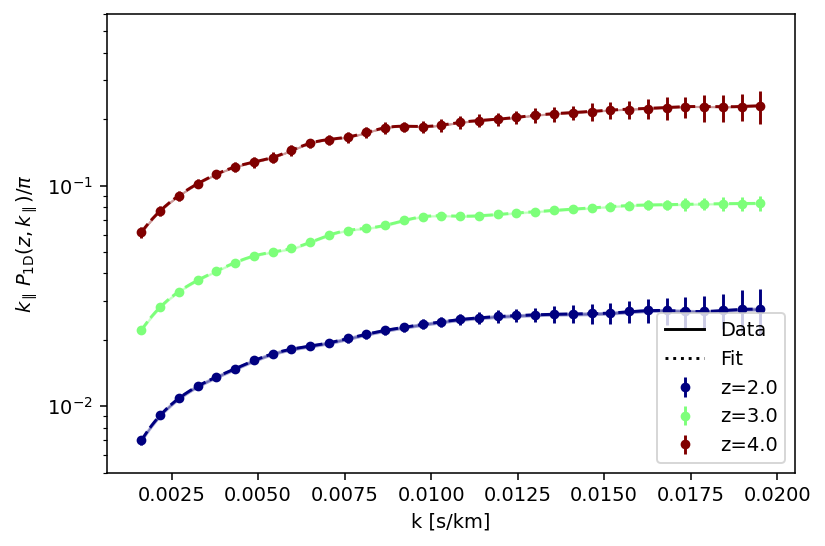

In [23]:
like.plot_p1d(plot_every_iz=4,values=m.values)

# Other cool things we can do with iminuit

In [24]:
# get Gaussian approximated errors
m.hesse()

------------------------------------------------------------------------------------------
|   | Name |   Value   | Hesse Err | Minos Err- | Minos Err+ | Limit-  | Limit+  | Fixed |
------------------------------------------------------------------------------------------
| 0 | x0   |   0.50    |   0.07    |            |            |         |         |       |
| 1 | x1   |   0.42    |   0.08    |            |            |         |         |       |
| 2 | x2   |   0.494   |   0.030   |            |            |         |         |       |
| 3 | x3   |   0.44    |   0.15    |            |            |         |         |       |
| 4 | x4   |   0.50    |   0.06    |            |            |         |         |       |
------------------------------------------------------------------------------------------

In [25]:
# get proper errors from likelihood scans
m.minos()

-------------------------------------------------
|       x0        |            Valid            |
-------------------------------------------------
|      Error      |    -6e-2     |     6e-2     |
|      Valid      |     True     |     True     |
|    At Limit     |    False     |    False     |
|     Max FCN     |    False     |    False     |
|     New Min     |    False     |    False     |
-------------------------------------------------
-------------------------------------------------
|       x1        |            Valid            |
-------------------------------------------------
|      Error      |    -7e-2     |     8e-2     |
|      Valid      |     True     |     True     |
|    At Limit     |    False     |    False     |
|     Max FCN     |    False     |    False     |
|     New Min     |    False     |    False     |
-------------------------------------------------
-------------------------------------------------
|       x2        |            Valid            |
-------------------------------------------------
|      Error      |   -2.9e-2    |    2.9e-2    |
|      Valid      |     True     |     True     |
|    At Limit     |    False     |    False     |
|     Max FCN     |    False     |    False     |
|     New Min     |    False     |    False     |
-------------------------------------------------
-------------------------------------------------
|       x3        |            Valid            |
-------------------------------------------------
|      Error      |    -0.16     |     0.14     |
|      Valid      |     True     |     True     |
|    At Limit     |    False     |    False     |
|     Max FCN     |    False     |    False     |
|     New Min     |    False     |    False     |
-------------------------------------------------
-------------------------------------------------
|       x4        |            Valid            |
-------------------------------------------------
|      Error      |    -6e-2     |     5e-2     |
|      Valid      |     True     |     True     |
|    At Limit     |    False     |    False     |
|     Max FCN     |    False     |    False     |
|     New Min     |    False     |    False     |
-------------------------------------------------

In [26]:
# get best-fit values
m.np_values()

array([0.49869145, 0.42423626, 0.49393819, 0.43920671, 0.50094777])

In [27]:
like.get_free_parameter_list()

['As', 'ns', 'ln_tau_0', 'ln_sigT_kms_0', 'ln_gamma_0']

In [28]:
# get parameters covariance
m.np_covariance()

array([[ 0.00425871,  0.00333865, -0.00188715,  0.00450453, -0.00295605],
       [ 0.00333865,  0.00575288, -0.00177144,  0.00222354, -0.00242654],
       [-0.00188715, -0.00177144,  0.00092877, -0.00244256,  0.00160976],
       [ 0.00450453,  0.00222354, -0.00244256,  0.02233979, -0.00526603],
       [-0.00295605, -0.00242654,  0.00160976, -0.00526603,  0.00350492]])

(array([0.27254083, 0.30625092, 0.33996102, 0.37367111, 0.40738121,
        0.4410913 , 0.4748014 , 0.5085115 , 0.54222159, 0.57593169]),
 array([-21.10351515, -22.36645489, -23.2390455 , -23.76277194,
        -23.99458865, -23.99754078, -23.82254133, -23.49511013,
        -23.01743113, -22.37886976]))

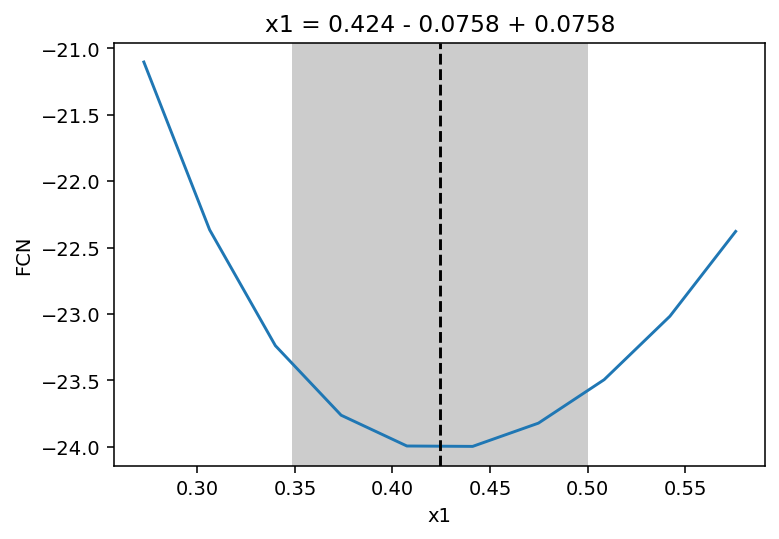

In [29]:
# scan one parameter and plot minus log posterior
m.draw_mnprofile(vname='x1',bins=10)

(array([0.14027666, 0.20670556, 0.27313446, 0.33956336, 0.40599226,
        0.47242116, 0.53885006, 0.60527896, 0.67170786, 0.73813676]),
 array([-22.29264948, -22.95966519, -23.46686284, -23.81463857,
        -23.99712766, -23.99514056, -23.77800463, -23.31969752,
        -22.61051099, -21.65389934]))

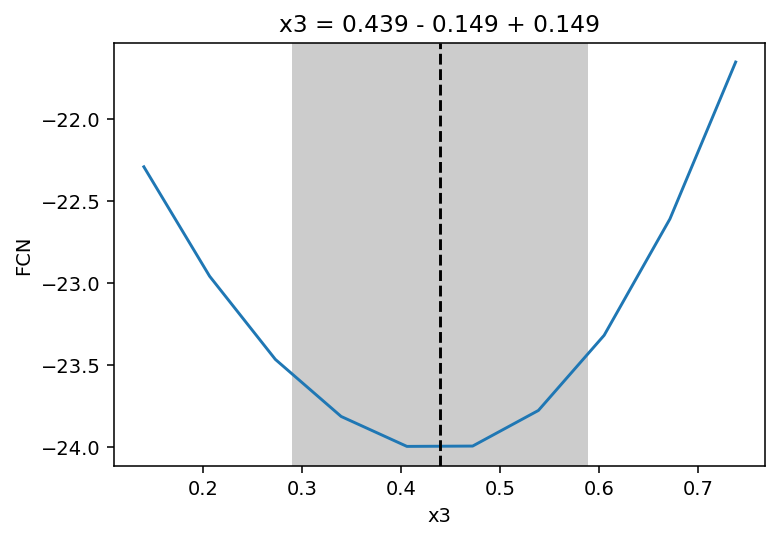

In [30]:
# for another parameter
m.draw_mnprofile(vname='x3',bins=10)

(array([0.36817391, 0.3819126 , 0.39565129, 0.40938998, 0.42312866,
        0.43686735, 0.45060604, 0.46434473, 0.47808342, 0.49182211,
        0.5055608 , 0.51929948, 0.53303817, 0.54677686, 0.56051555,
        0.57425424, 0.58799293, 0.60173162, 0.6154703 , 0.62920899]),
 array([0.27254083, 0.28850877, 0.30447671, 0.32044465, 0.33641259,
        0.35238053, 0.36834847, 0.38431641, 0.40028435, 0.41625229,
        0.43222023, 0.44818817, 0.46415611, 0.48012405, 0.49609199,
        0.51205993, 0.52802787, 0.54399581, 0.55996375, 0.57593169]),
 array([[1.53192738e+02, 1.46040640e+02, 1.38806424e+02, 1.31542621e+02,
         1.24299704e+02, 1.17125331e+02, 1.10063785e+02, 1.03155613e+02,
         9.64374480e+01, 8.99419982e+01, 8.36981601e+01, 7.77312390e+01,
         7.20632388e+01, 6.67131912e+01, 6.16974984e+01, 5.70302627e+01,
         5.27235838e+01, 4.87878057e+01, 4.52317014e+01, 4.20625868e+01],
        [1.35011795e+02, 1.27664960e+02, 1.20306608e+02, 1.12991789e+02,
         1.05

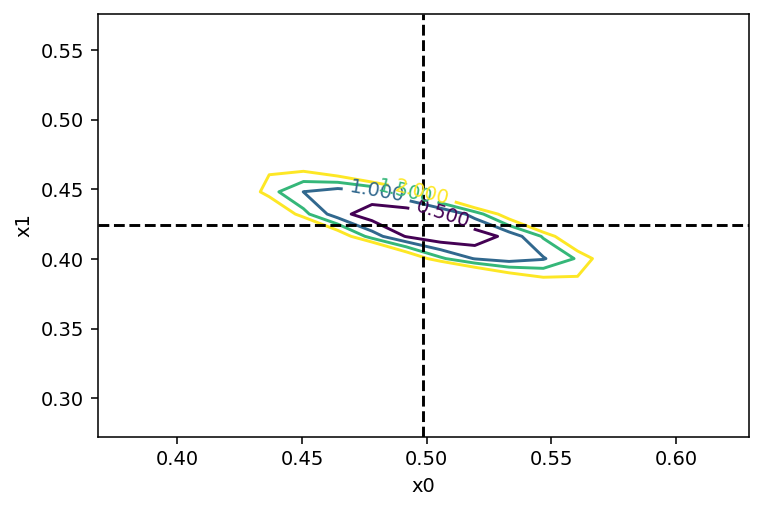

In [31]:
# 2D contours
m.draw_contour('x0','x1',bins=20)

In [32]:
# matrix correlations
m.matrix(correlation=True)

-------------------------------------------
|    |     x0     x1     x2     x3     x4 |
-------------------------------------------
| x0 |  1.000  0.675 -0.949  0.462 -0.765 |
| x1 |  0.675  1.000 -0.766  0.196 -0.540 |
| x2 | -0.949 -0.766  1.000 -0.536  0.892 |
| x3 |  0.462  0.196 -0.536  1.000 -0.595 |
| x4 | -0.765 -0.540  0.892 -0.595  1.000 |
-------------------------------------------